In [1]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate();

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [2]:
using Revise
using JuMP
using Plots
using DisjunctiveProgramming
using ToQUBO
using DisjunctiveToQUBO
using HiGHS
using DWave

    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PySA/1uIKV/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/DWave/jgSmA/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PythonCall/wXfah/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/DWave/SF65J/CondaPkg.toml


    CondaPkg Dependencies already up to date


In [3]:
# TTT-Tolerance
const τ = 0.05 # 5%

0.05

In [4]:
includet("squares.jl");

## Squares Model

$$
\begin{array}{rll}
\displaystyle \min_{x, y, Y} & x_1 - x_2 + y_1 + 5y_2 \\
            \textrm{s.t.} & Y_{1} \veebar Y_{2} \\
                ~ & \left[
                        \begin{array}{c}
                            Y_1 \\
                            -2 \leq x_{1}, x_{2} \leq -1 \\
                        \end{array}
                    \right] \bigvee
                    \left[
                        \begin{array}{c}
                            Y_2 \\
                            1 \leq x_{1}, x_{2} \leq 2 \\
                        \end{array}
                    \right] \\
                ~ & x_{i} \in [-2, 2] \\
                ~ & Y_{i} \in \{ \textrm{True}, \textrm{False} \}  & \forall i \\
                ~ & y_{i} \in \{ 0, 1 \}  & \forall i \\
                ~ & Y_{i} \iff y_{i} = 1  & \forall i \\
\end{array}
$$

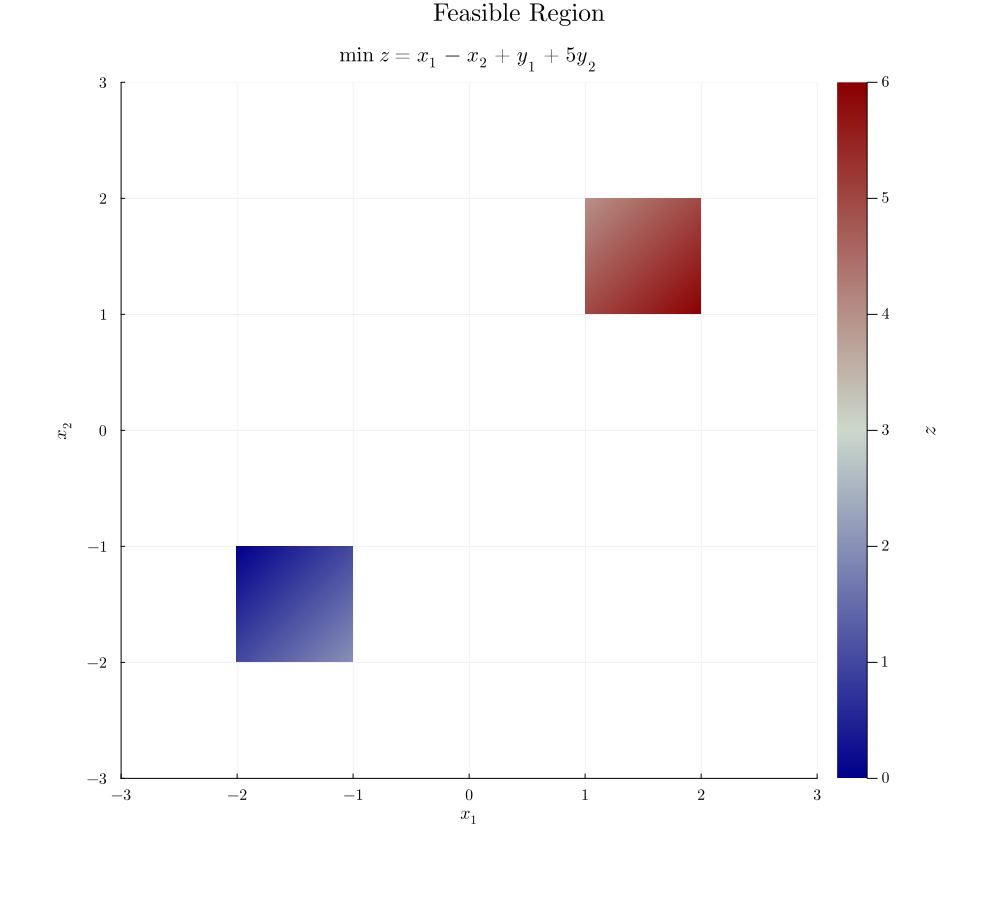

In [5]:
let plt = plot_square_feasible()
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "square-feasible.pdf"))

    plt
end

### Optimal Solution

In [6]:
x⃰, z⃰ = let model = solve_gdp_squares(HiGHS.Optimizer; method=BigM(3.0, false)) do m
        set_silent(m)
    end

    value.(model[:x]), objective_value(model)
end

([-2.0, -1.0], 0.0)

## Big-M Reformulation

In [7]:
M = 3.0

bigm_sa_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

bigm_qa_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "return_embedding", true)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end;

In [8]:
open(joinpath(@__DIR__, "data", "squares-bigm-sa.txt"), "w") do io
    println(io, compilation_summary(bigm_sa_model))
    println(io, sampling_summary(bigm_sa_model, z⃰ * (1 + τ))) # 5% above optimal
    println(io, solution_summary(bigm_sa_model))
end

open(joinpath(@__DIR__, "data", "squares-bigm-qa.txt"), "w") do io
    println(io, compilation_summary(bigm_qa_model))
    println(io, sampling_summary(bigm_qa_model, z⃰ * (1 + τ))) # 5% above optimal
    println(io, solution_summary(bigm_qa_model))
end;

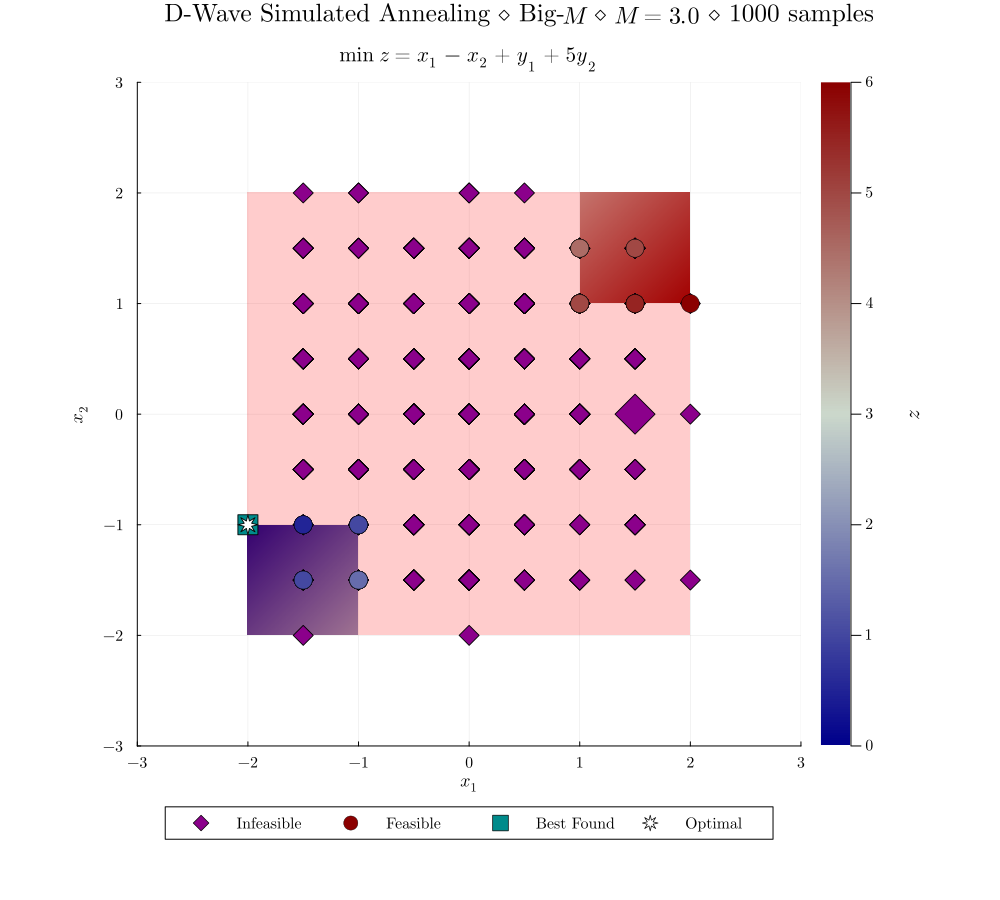

In [9]:
let plt = plot_square_bigm(
        bigm_sa_model,
        x⃰,
        M;
        plot_title="D-Wave Simulated Annealing $(diamond) Big-\$M\$ $(diamond) \$M = $(M)\$ $(diamond) $(result_count(bigm_qa_model)) samples",
        feasible = x -> (x < 7),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "squares-bigm-sa.pdf"))

    plt
end

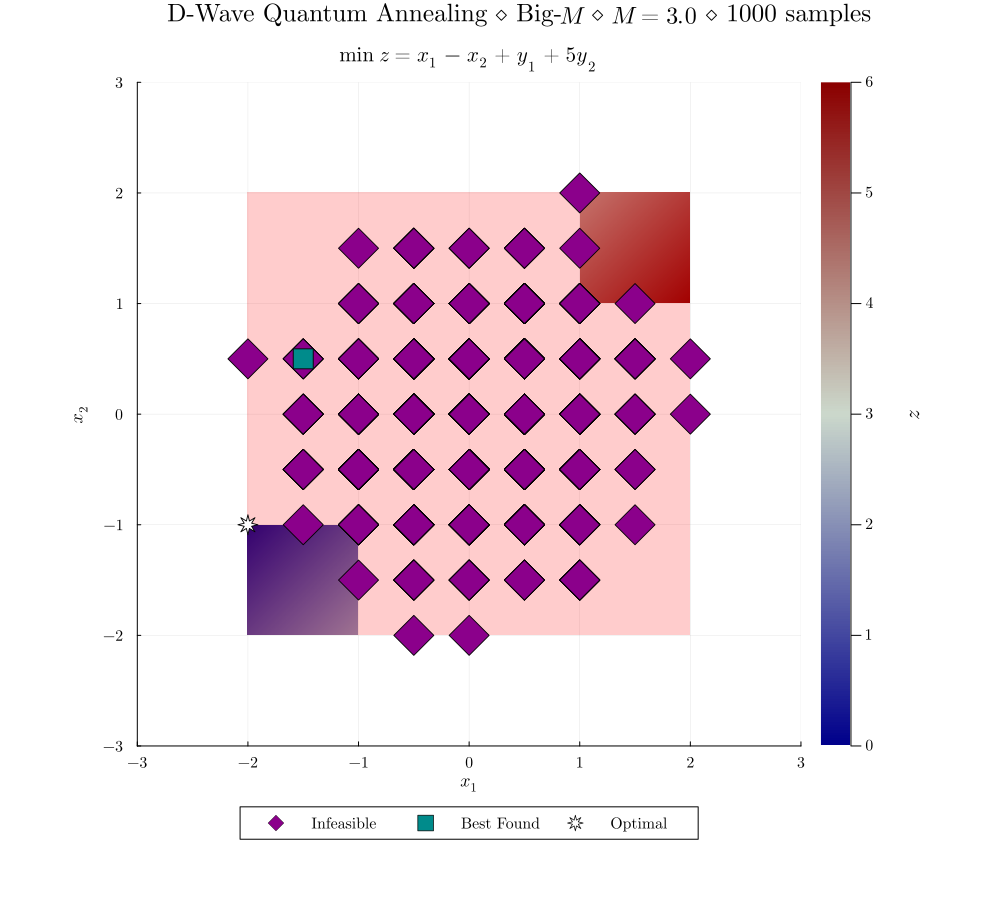

In [10]:
let plt = plot_square_bigm(
        bigm_qa_model,
        x⃰,
        M;
        plot_title="D-Wave Quantum Annealing $(diamond) Big-\$M\$ $(diamond) \$M = $(M)\$ $(diamond) $(result_count(bigm_qa_model)) samples",
        feasible = x -> (x < 7),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "squares-bigm-qa.pdf"))

    plt
end

## Hull Reformulation

In [11]:
M = 3.0

hull_sa_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Hull()
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

hull_qa_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Optimizer),
    method = Hull()
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "return_embedding", true)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end;

In [12]:
open(joinpath(@__DIR__, "data", "squares-hull-sa.txt"), "w") do io
    println(io, compilation_summary(hull_sa_model))
    println(io, sampling_summary(hull_sa_model, z⃰ * (1 + τ))) # 5% above optimal
    println(io, solution_summary(hull_sa_model))
end

open(joinpath(@__DIR__, "data", "squares-hull-qa.txt"), "w") do io
    println(io, compilation_summary(hull_qa_model))
    println(io, sampling_summary(hull_qa_model, z⃰ * (1 + τ))) # 5% above optimal
    println(io, solution_summary(hull_qa_model))
end;

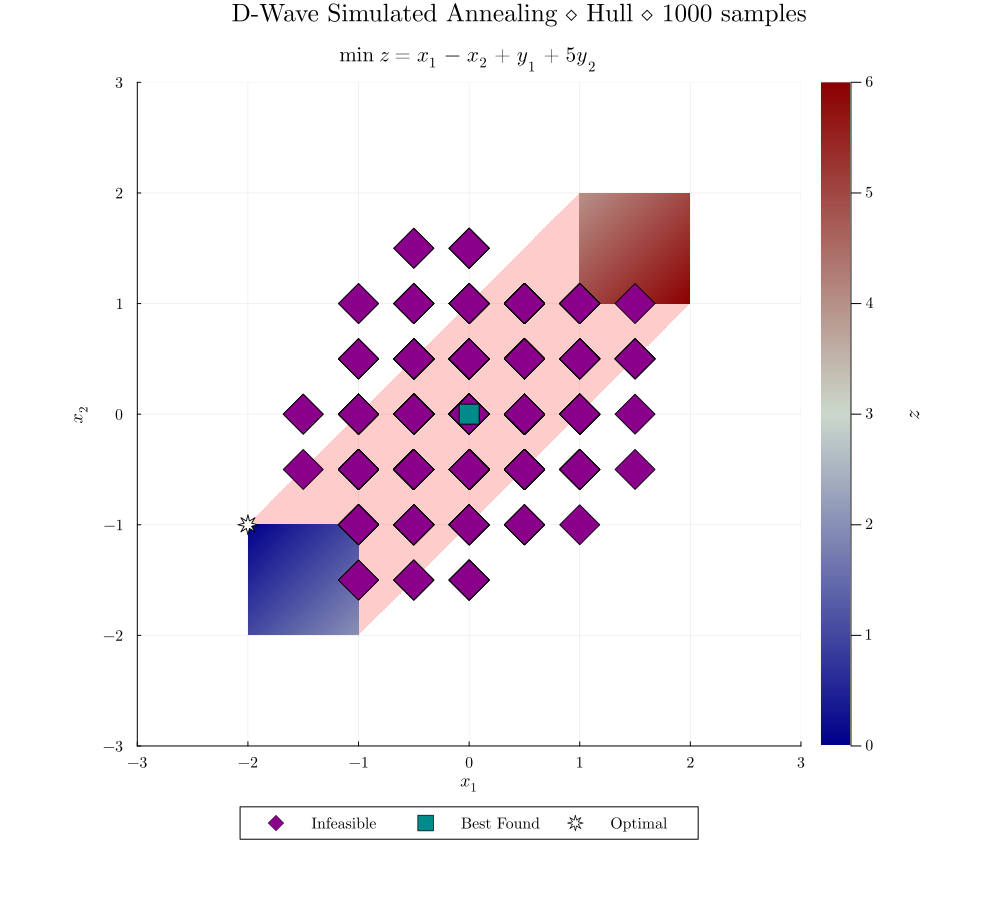

In [13]:
let plt = plot_square_hull(
        hull_sa_model,
        x⃰;
        plot_title="D-Wave Simulated Annealing $(diamond) Hull $(diamond) $(result_count(bigm_qa_model)) samples",
        feasible = x -> (x < 7),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "squares-hull-sa.pdf"))

    plt
end

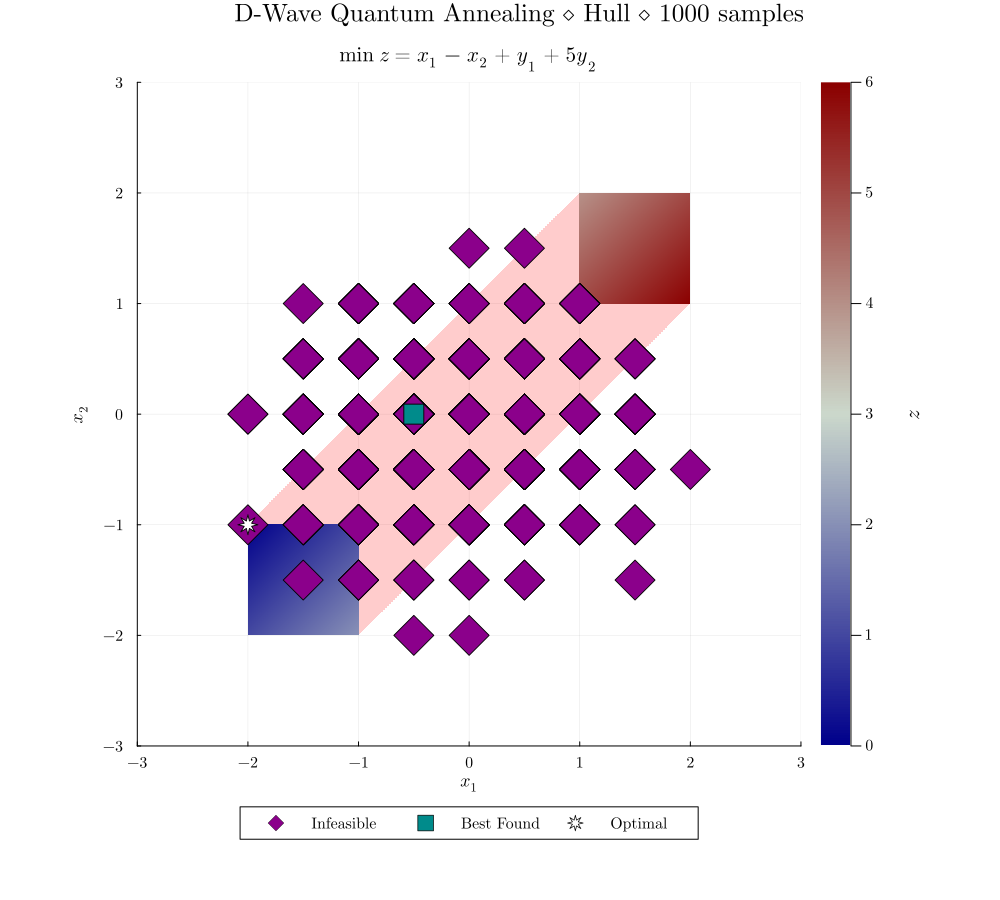

In [14]:
let plt = plot_square_hull(
        hull_qa_model,
        x⃰;
        plot_title="D-Wave Quantum Annealing $(diamond) Hull $(diamond) $(result_count(bigm_qa_model)) samples",
        feasible = x -> (x < 7),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "squares-hull-qa.pdf"))

    plt
end

## Indicator Reformulation

In [15]:
ind_sa_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Indicator()
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

ind_qa_model = solve_gdp_squares(
    () -> ToQUBO.Optimizer(DWave.Optimizer),
    method = Indicator()
) do m
    set_attribute(m, "num_reads",  1_000)
    set_attribute(m, "return_embedding", true)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end;

In [16]:
open(joinpath(@__DIR__, "data", "squares-ind-sa.txt"), "w") do io
    println(io, compilation_summary(ind_sa_model))
    println(io, sampling_summary(ind_sa_model, z⃰ * (1 + τ))) # 5% above optimal
    println(io, solution_summary(ind_sa_model))
end

open(joinpath(@__DIR__, "data", "squares-ind-qa.txt"), "w") do io
    println(io, compilation_summary(ind_qa_model))
    println(io, sampling_summary(ind_qa_model, z⃰ * (1 + τ))) # 5% above optimal
    println(io, solution_summary(ind_qa_model))
end;

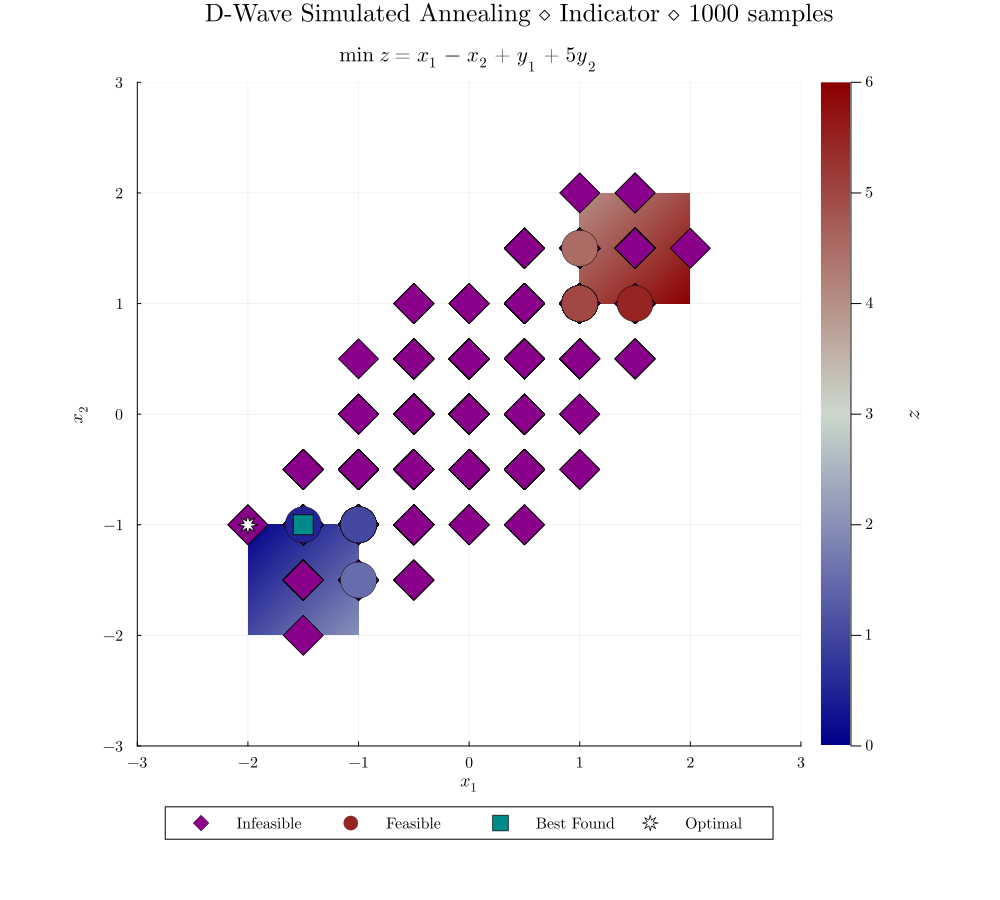

In [22]:
let plt = plot_square_indicator(
    ind_sa_model,
    x⃰;
    plot_title = "D-Wave Simulated Annealing $(diamond) Indicator $(diamond) $(result_count(ind_sa_model)) samples",
    feasible = <(7)
)
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "square-ind-sa.pdf"))

    plt
end

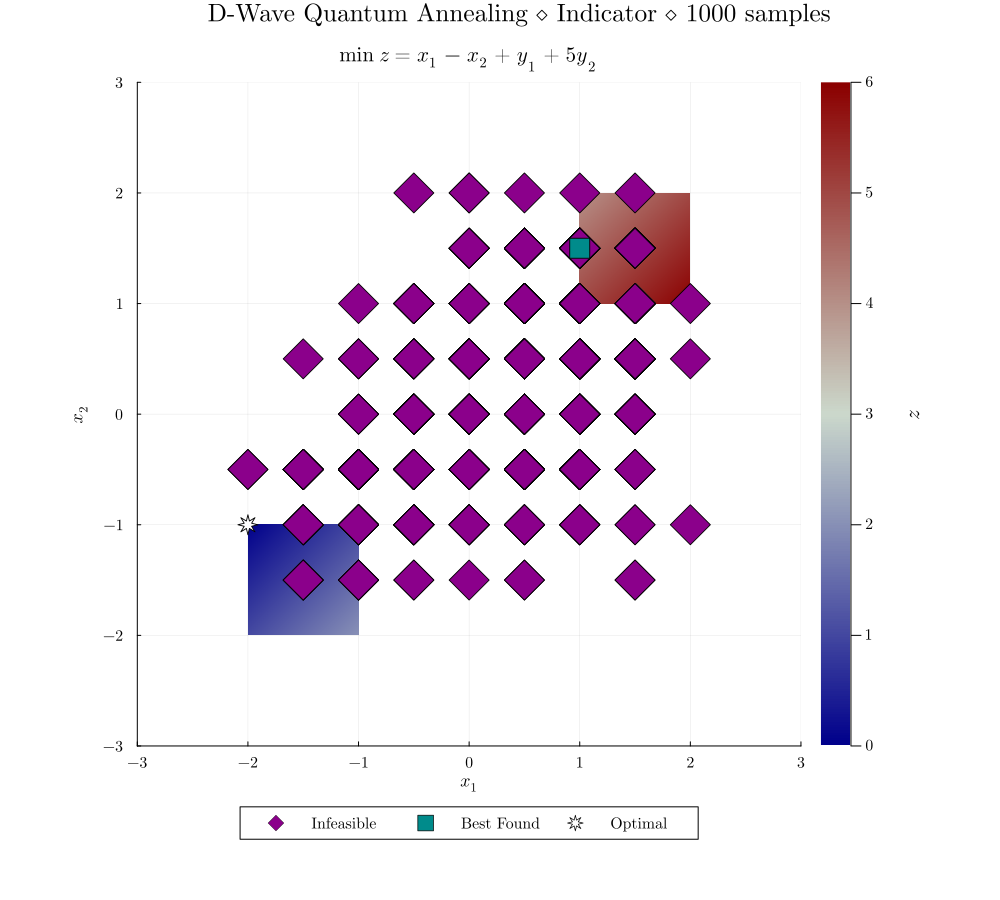

In [23]:
let plt = plot_square_indicator(ind_qa_model, x⃰; plot_title = "D-Wave Quantum Annealing $(diamond) Indicator $(diamond) $(result_count(ind_qa_model)) samples", feasible = <(7))
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "square-ind-qa.pdf"))

    plt
end

## Indicator-Interval Reformulation

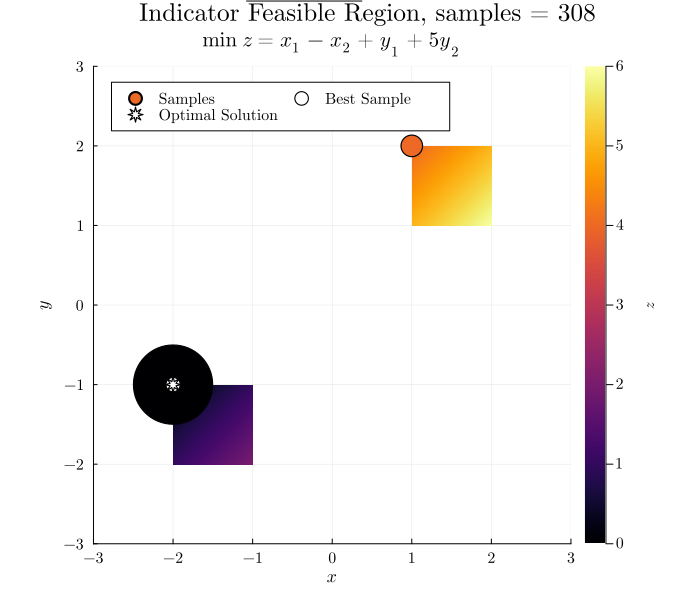

In [116]:
plot_square_indicator(indint_model, x⃰)